## RFM + Surge Weighted Segmentation

Extending the classic RFM framework (Recency, Frequency, Monetary) by incorporating Surge Exposure as a fourth dimension. This allows us to logically segment RideWise riders based on their behavioural attitudes and sensitivity to surge pricing.

### Weighted Factors
- **Recency (0.4)** → strongest churn predictor  
- **Frequency (0.3)** → loyalty indicator  
- **Monetary (0.2)** → rider value contribution  
- **Surge (0.1)** → sensitivity/tolerance to surge pricing

### Rider Segments
- **High-Value Loyalists**
- **Regular Commuters**
- **Occasional Riders**
- **At‑Risk Users**

### Outcome
This weighted segmentation provides a **balanced view of loyalty and churn probability**, guiding RideWise in retention strategies, promotions, and win-back campaigns.


#

**mounting the google drive**

In [2]:
# from google.colab import drive

# # Mount Google Drive
# drive.mount('/content/drive')

**Importing the required libraries**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings # Ignore all warnings
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv('../data/processed_data/trip_riders_drivers_df.csv')

In [5]:
df.shape

(200000, 36)

In [6]:
df.head(2)

,trip_id,user_id,driver_id,fare,surge_multiplier,tip,payment_type,pickup_time,dropoff_time,pickup_lat,...,dropoff_day,trip_duration_mins,rider_age_group,pickup_hour,pickup_date,pickup_day,pickup_month,pickup_year,pickup_period,pickup_season
0,T090716,R00102,D00000,5.07,1.0,0.00,Mobile Money,2025-03-14 08:29:08+00:00,2025-03-14 09:08:08+00:00,30.013226,...,Friday,39,Mid-Career Adults,8,2025-03-14,Friday,March,2025,Morning,Spring
1,T113266,R01412,D00000,19.69,1.0,0.44,Mobile Money,2025-03-04 08:23:47+00:00,2025-03-04 09:10:47+00:00,30.131991,...,Tuesday,47,Young Starters,8,2025-03-04,Tuesday,March,2025,Morning,Spring


**Inspecting the Data quality**

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 36 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   trip_id             200000 non-null  object 
 1   user_id             200000 non-null  object 
 2   driver_id           200000 non-null  object 
 3   fare                200000 non-null  float64
 4   surge_multiplier    200000 non-null  float64
 5   tip                 200000 non-null  float64
 6   payment_type        200000 non-null  object 
 7   pickup_time         200000 non-null  object 
 8   dropoff_time        200000 non-null  object 
 9   pickup_lat          200000 non-null  float64
 10  pickup_lng          200000 non-null  float64
 11  dropoff_lat         200000 non-null  float64
 12  dropoff_lng         200000 non-null  float64
 13  weather             200000 non-null  object 
 14  loyalty_status      200000 non-null  object 
 15  user_signup_date    200000 non-nul

 🧾 **Data Quality Summary**

- The output above indicates that there are no missing values across the dataset.

- Some columns were duplicated during the merging process and require cleaning.

However, a few columns contain inappropriate data types that may require conversion or correction.

---


### **Data Cleaning**

In [8]:
# Convert pickup and dropoff times safely, keeping timezone info
df['pickup_time'] = pd.to_datetime(df['pickup_time'], utc=True, errors='coerce')
df['dropoff_time'] = pd.to_datetime(df['dropoff_time'], utc=True, errors='coerce')
df['user_signup_date'] = pd.to_datetime(df['user_signup_date'], utc=True, errors='coerce')
df['driver_signup_date'] = pd.to_datetime(df['driver_signup_date'], utc=True, errors='coerce')
df['last_active'] = pd.to_datetime(df['last_active'], utc=True, errors='coerce')
df['dropoff_date'] = pd.to_datetime(df['dropoff_date'], utc=True, errors='coerce')



# Check the datatypes
print(df['pickup_time'].dtype)
print(df['dropoff_time'].dtype)
print(df['user_signup_date'].dtype)
print(df['driver_signup_date'].dtype)

datetime64[ns, UTC]
datetime64[ns, UTC]
datetime64[ns, UTC]
datetime64[ns, UTC]


In [9]:
df[['trip_id','user_id','fare' ,'dropoff_date']].describe(include='all').transpose()

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
trip_id,200000,200000,T090716,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
user_id,200000,10000,R08152,42,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fare,200000.0,NaN,NaN,NaN,15.401285,2.97,11.0,14.13,18.35,82.74,6.163199
dropoff_date,200000,NaN,NaN,NaN,2024-10-26 13:50:16.512000256+00:00,2024-04-26 00:00:00+00:00,2024-07-28 00:00:00+00:00,2024-10-27 00:00:00+00:00,2025-01-26 00:00:00+00:00,2025-04-27 00:00:00+00:00,NaN


**Checking the last dropoff date**

In [10]:
last_dropoff = df['dropoff_time'].max()
last_dropoff

Timestamp('2025-04-28 00:12:26+0000', tz='UTC')

**Compute RFM(s) metrics per `user_id` and save results in a DataFrame named `rfm_table`**

In [11]:
rfm_table = df.groupby('user_id').agg(
    {
    'dropoff_date': lambda x: (last_dropoff - x.max()).days + 1,
    'trip_id': 'count',
    'fare': 'sum',
    'surge_multiplier': lambda x: (x > 1.0).mean()}   # % of trips with surge
    )

rfm_table.head().reset_index()    # Preview the results

,user_id,dropoff_date,trip_id,fare,surge_multiplier
0,R00000,27,25,366.05,0.280000
1,R00001,7,14,180.53,0.214286
2,R00002,16,24,378.99,0.375000
3,R00003,63,9,121.47,0.333333
4,R00004,14,16,268.43,0.437500


In [12]:
rfm_table.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, R00000 to R09999
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   dropoff_date      10000 non-null  int64  
 1   trip_id           10000 non-null  int64  
 2   fare              10000 non-null  float64
 3   surge_multiplier  10000 non-null  float64
dtypes: float64(2), int64(2)
memory usage: 390.6+ KB


This demonstrate the fact that all riders were exposed to surge multiplier at one point or the other.

---

**Renaming dropoff_date, trip_id, and fare into recency, frequency, monetary and surge multiplier respectively**

In [13]:
rfm_table.rename(columns= {
    'dropoff_date': 'recency',
    'trip_id': 'frequency',
    'fare': 'monetary',
    'surge_multiplier': 'surge_exposure(%)'
}, inplace=True)
rfm_table.head(3).reset_index()

,user_id,recency,frequency,monetary,surge_exposure(%)
0,R00000,27,25,366.05,0.280000
1,R00001,7,14,180.53,0.214286
2,R00002,16,24,378.99,0.375000


**Plotting the distribution of `recency`, `frequency`, `monetary`, and `surge exposure`**

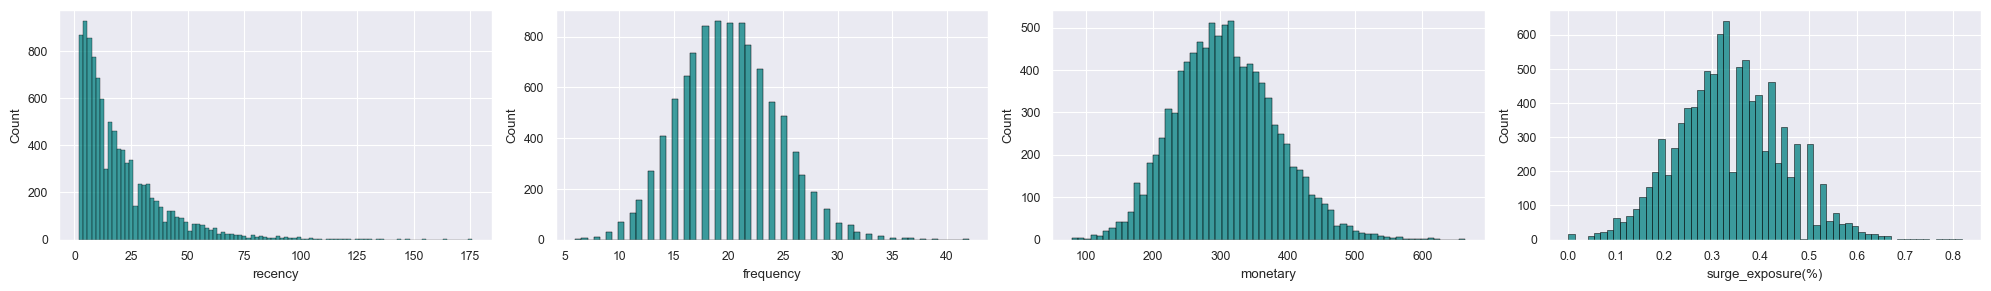

In [14]:
sns.set(style='darkgrid', palette='Set2', context='paper')
plt.figure(figsize=(20,3))
plt.subplot(1,4,1)
sns.histplot(rfm_table['recency'], color='teal', edgecolor= 'black')
plt.subplot(1,4,2)
sns.histplot(rfm_table['frequency'], color='teal', edgecolor= 'black')
plt.subplot(1,4,3)
sns.histplot(rfm_table['monetary'], color='teal', edgecolor= 'black')
plt.subplot(1,4,4)
sns.histplot(rfm_table['surge_exposure(%)'], color='teal', edgecolor= 'black')
plt.tight_layout()
plt.show();

## 📊 Brief Insights from the RFM + Surge Exposure Distributions

- **Recency:** The distribution is heavily skewed towards lower values, indicating that a large proportion of users have engaged recently. This suggests strong short-term activity, but also highlights the need to monitor those with higher recency scores who may be drifting away.

- **Frequency:** The bell-shaped distribution implies a balanced mix of occasional and regular users, with most customers booking around 20 trips. This central tendency is useful for identifying outliers who may represent either high-value loyalists or low-engagement churn risks.

- **Monetary:** The monetary histogram mirrors the frequency pattern, with most users spending around £300. This consistency supports reliable segmentation and pricing strategy.

- **Surge Exposure (%):** The surge exposure distribution centres around 30%, with a spread from 0% to 80%. This suggests that while many users experience surge pricing moderately, a subset is frequently exposed. Understanding how surge impacts retention and satisfaction could inform dynamic pricing and loyalty interventions.

Overall, these distributions offer a solid foundation for behavioural segmentation, with the surge exposure metric adding a valuable layer of insight into price sensitivity and user tolerance.


**Do visualize the average surge multiplier by no of trips**

**do fare by total trips**

**Visualizing:**
- **The top 5 riders with highest surge exposure**
- **The correlation between number of trips with the Surge exposure**

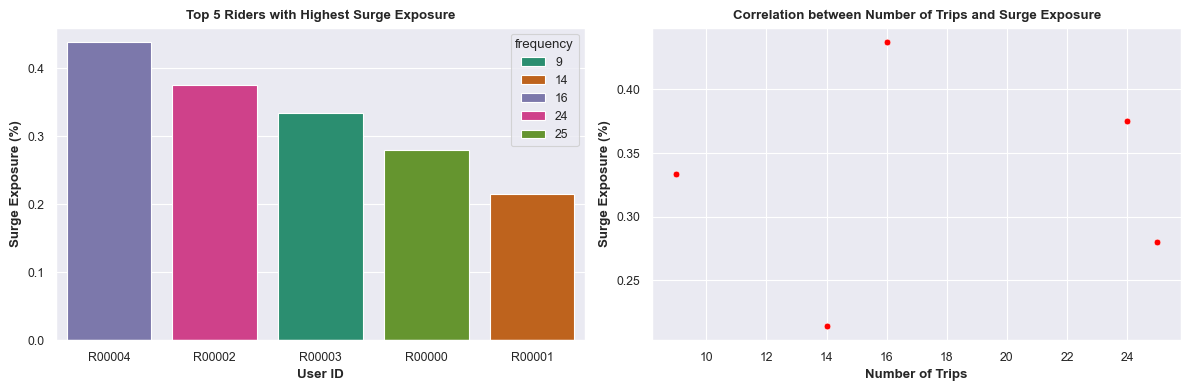

In [15]:
avg_surge_by_trips = rfm_table.groupby('user_id').agg(
    {
        'frequency': 'sum',
        'surge_exposure(%)': 'mean'
    }
).head()
top_5_riders_with_avg_surge = avg_surge_by_trips.sort_values(by='surge_exposure(%)', ascending=False).reset_index()
top_5_riders_with_avg_surge

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.barplot(x='user_id', y='surge_exposure(%)', data=top_5_riders_with_avg_surge, hue='frequency', palette='Dark2')
plt.title('Top 5 Riders with Highest Surge Exposure',  weight='bold')
plt.xlabel('User ID',  weight='bold')
plt.ylabel('Surge Exposure (%)',  weight='bold')

plt.subplot(1,2,2)
sns.scatterplot(x='frequency', y='surge_exposure(%)', data=top_5_riders_with_avg_surge, color='red')
plt.title('Correlation between Number of Trips and Surge Exposure', weight='bold')
plt.xlabel('Number of Trips', weight='bold')
plt.ylabel('Surge Exposure (%)', weight='bold')
plt.tight_layout()
plt.show();

- User R00004 has the highest surge exposure (around 40%), though their ride frequency is relatively modest (16 rides), which suggests fewer rides but a strong impact from surge pricing.

- User R00002 shows the second‑highest surge exposure (just under 30%) with a higher ride frequency (24 rides) while user R00003 has moderate surge exposure (around 20%) but a lower ride frequency (9 rides).

- User R00000 records slightly lower surge exposure (just under 20%) but the highest ride frequency (25 rides), and user R00001 has the lowest surge exposure among the top five (around 15%) with a mid‑range frequency (14 rides), showing moderate activity and relatively limited surge effect.

**Overall, the chart highlights that high surge exposure doesn’t always align with high ride frequency — some riders with fewer trips are disproportionately impacted by surge pricing.**

---

#####

#### **Plotting to see the further correlation between the variables**

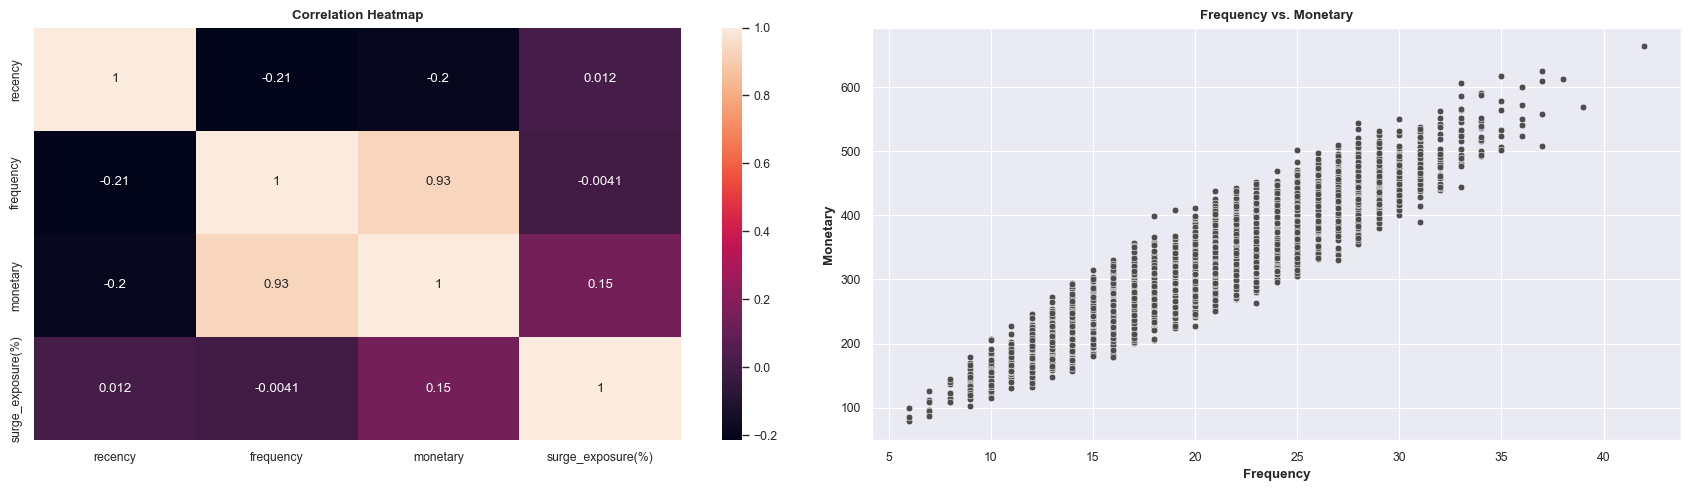

In [16]:
plt.figure(figsize=(17,5))
plt.subplot(1,2,1)
sns.heatmap(rfm_table.corr(), annot=True)
plt.title('Correlation Heatmap', weight='bold')

plt.subplot(1,2,2)
sns.scatterplot(x='frequency', y='monetary', data=rfm_table, color='0.3')
plt.title('Frequency vs. Monetary', weight='bold')
plt.xlabel('Frequency', weight='bold')
plt.ylabel('Monetary', weight='bold')
plt.tight_layout()
plt.show();

- Frequency and Monetary show a very strong positive correlation (0.93), meaning riders who take more trips also tend to spend more.

- Recency and Frequency/Monetary both have moderate negative correlations (around ‑0.2), suggesting that longer gaps since last activity are linked to fewer rides and lower spending.

- Surge Exposure shows only weak correlations with the other variables, indicating it operates independently of ride frequency, spending, or recency.

**In essence, ride frequency and spending move closely together, while surge exposure behaves more like a separate factor.**

---

### **Plotting the most and least recent riders**

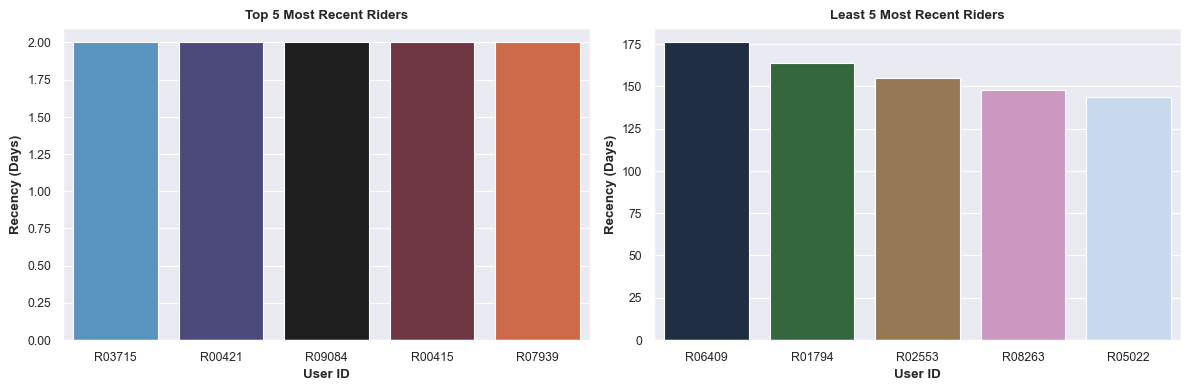

In [17]:
top_5_most_recent_riders = rfm_table.sort_values('recency', ascending=True).head(5)
least_5_most_recent_riders = rfm_table.sort_values('recency', ascending=False).head(5)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.barplot(x='user_id', y='recency', data=top_5_most_recent_riders.reset_index(), palette='icefire')
plt.title('Top 5 Most Recent Riders', weight='bold')
plt.xlabel('User ID', weight='bold')
plt.ylabel('Recency (Days)', weight='bold')

plt.subplot(1,2,2)
sns.barplot(x='user_id', y='recency', data=least_5_most_recent_riders.reset_index(), palette='cubehelix')
plt.title('Least 5 Most Recent Riders', weight='bold')
plt.xlabel('User ID', weight='bold')
plt.ylabel('Recency (Days)', weight='bold')
plt.tight_layout()
plt.show();

*Top 5 Most Recent Riders*

- These riders (e.g. R00041, R04737) have all used the service within the last 2 days, showing very fresh engagement.

- Their activity suggests strong current loyalty and potential for continued usage.

*Least 5 Most Recent Riders*

- These riders (e.g. R06409, R01794) have not used the service for 145–175 days, indicating long inactivity.

- They represent churn risk and may need targeted re‑engagement strategies.

---

### **Plotting the most and least frequent riders**

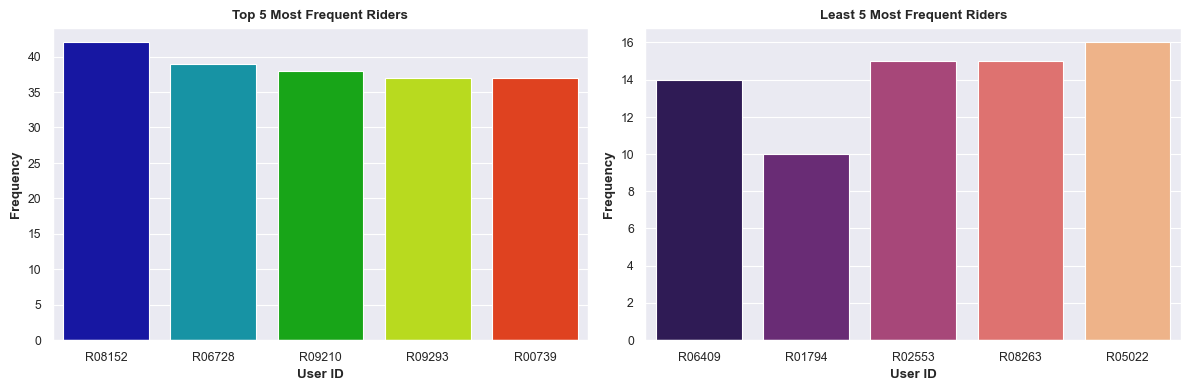

In [18]:
top_5_most_frequent_riders = rfm_table.sort_values('frequency', ascending=False).head(5)
least_5_most_frequent_riders = rfm_table.sort_values('frequency', ascending=True).head(5)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.barplot(x='user_id', y='frequency', data=top_5_most_frequent_riders.reset_index(), palette='nipy_spectral')
plt.title('Top 5 Most Frequent Riders', weight='bold')
plt.xlabel('User ID', weight='bold')
plt.ylabel('Frequency', weight='bold')

plt.subplot(1,2,2)
sns.barplot(x='user_id', y='frequency', data=least_5_most_recent_riders.reset_index(), palette='magma')
plt.title('Least 5 Most Frequent Riders', weight='bold')
plt.xlabel('User ID', weight='bold')
plt.ylabel('Frequency', weight='bold')
plt.tight_layout()
plt.show();

*Top 5 Most Frequent Riders*

- Riders such as R08152 and R06728 show very high ride counts (around 37–42), highlighting consistent and loyal usage.

- Their behaviour suggests they are core users who contribute significantly to overall service demand.

*Least 5 Most Frequent Riders*

- Riders like R01794 and R02553 have much lower ride counts (around 10–16), indicating limited engagement.

- These users may represent occasional riders or potential churn risks, requiring tailored strategies to increase activity.

---

##

### **Converting the RFM segmentation i.e Recency, Frequency, Monetary and the Surge values into scores based on quantiles**

**RFM Concatenation:** Finally, the individual r, f, m, and s scores are converted to strings and concatenated to create a combined rfm_concat string (e.g., '4444' for the best customers, '1111' for the worst).

In [19]:
rfm_table['r'] = pd.qcut(rfm_table['recency'], q=4, labels=[4,3,2,1])
rfm_table['f'] = pd.qcut(rfm_table['frequency'], q=4, labels=[1,2,3,4])
rfm_table['m'] = pd.qcut(rfm_table['monetary'], q=4, labels=[1,2,3,4])
rfm_table['s'] = pd.qcut(rfm_table['surge_exposure(%)'], q=4, labels=[1,2,3,4])
rfm_table['rfm_concat'] = rfm_table['r'].astype(str) + rfm_table['f'].astype(str) + rfm_table['m'].astype(str)

rfm_table.head().reset_index()

,user_id,recency,frequency,monetary,surge_exposure(%),r,f,m,s,rfm_concat
0,R00000,27,25,366.05,0.280000,2,4,4,2,244
1,R00001,7,14,180.53,0.214286,4,1,1,1,411
2,R00002,16,24,378.99,0.375000,2,4,4,3,244
3,R00003,63,9,121.47,0.333333,1,1,1,2,111
4,R00004,14,16,268.43,0.437500,3,1,2,4,312


#

#### **Calculating the combined rfm_score for each customer and then displaying the first few rows of the updated rfm_table.**

In [20]:
rfm_table['rfm_score'] = rfm_table[['r', 'f', 'm', 's']].sum(axis=1)
rfm_table.head().reset_index()

,user_id,recency,frequency,monetary,surge_exposure(%),r,f,m,s,rfm_concat,rfm_score
0,R00000,27,25,366.05,0.280000,2,4,4,2,244,12
1,R00001,7,14,180.53,0.214286,4,1,1,1,411,7
2,R00002,16,24,378.99,0.375000,2,4,4,3,244,13
3,R00003,63,9,121.47,0.333333,1,1,1,2,111,5
4,R00004,14,16,268.43,0.437500,3,1,2,4,312,10


In [21]:
rfm_table['rfm_score'].max()

16

In [22]:
rfm_table['rfm_score'].min()

4

### **The deployed 4 Customer Segments for Ride Wise**

| Segment | Characteristics | Churn Risk |
|---------|-----------------|------------|
| High‑Value Loyalists | Frequent riders, high spend, consistent usage patterns | Low risk — maintain loyalty with perks |
| Regular Commuters | Regular riders, but churn risk rises under surge pricing. | Medium risk — vulnerable to alternatives |
| Occasional Riders | Infrequent trips, higher churn risk, sporadic usage | High risk — easily churn if not engaged |
| At‑Risk Users | Long gaps since last ride, declining activity | Critical risk — require reactivation campaigns |

---


In [23]:
def rfm_segmentation(x):
  if x <= 6:
    return 'At Risk Users'
  elif x <= 10:
    return 'Occasional Riders'
  elif x <= 14:
    return 'Regular Commuters'
  else:
    return 'High‑Value Loyalists'

rfm_table['riders_segmentation'] = rfm_table['rfm_score'].apply(rfm_segmentation)
rfm_table.head().reset_index()

,user_id,recency,frequency,monetary,surge_exposure(%),r,f,m,s,rfm_concat,rfm_score,riders_segmentation
0,R00000,27,25,366.05,0.280000,2,4,4,2,244,12,Regular Commuters
1,R00001,7,14,180.53,0.214286,4,1,1,1,411,7,Occasional Riders
2,R00002,16,24,378.99,0.375000,2,4,4,3,244,13,Regular Commuters
3,R00003,63,9,121.47,0.333333,1,1,1,2,111,5,At Risk Users
4,R00004,14,16,268.43,0.437500,3,1,2,4,312,10,Occasional Riders


In [24]:
segmentation_in_total = rfm_table['riders_segmentation'].value_counts().reset_index()
segmentation_in_total

,riders_segmentation,count
0,Occasional Riders,4452
1,Regular Commuters,3696
2,At Risk Users,1360
3,High‑Value Loyalists,492


### **Visualizing the distribution of Riders Segments**

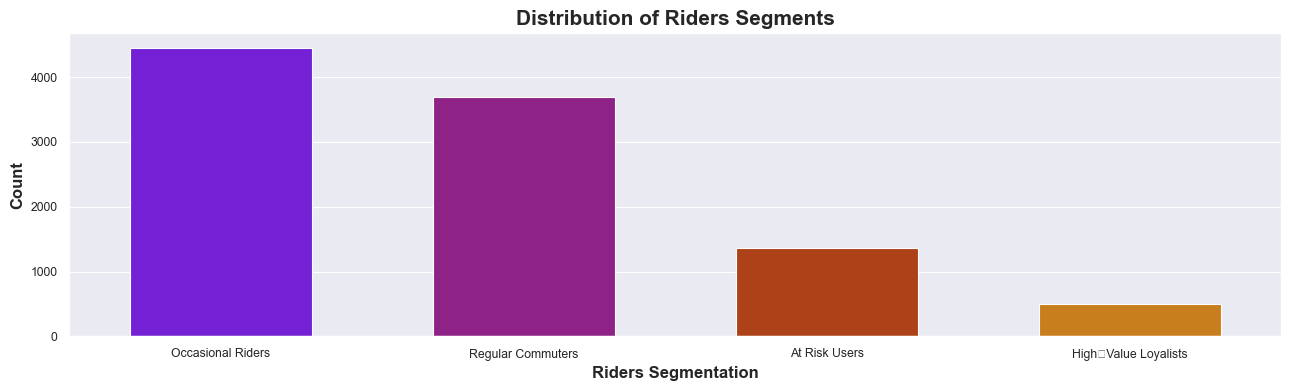

In [25]:
plt.figure(figsize=(13,4))
sns.barplot(x='riders_segmentation', y='count', data=segmentation_in_total, palette='gnuplot', width=0.6)
plt.title('Distribution of Riders Segments', fontsize=15, weight='bold')
plt.xlabel('Riders Segmentation', fontsize=12, weight='bold')
plt.ylabel('Count', fontsize=12, weight='bold')
plt.tight_layout()
plt.show();

#

### **Implementing the Weighted Score on the recently performed RFM Table**

Calculating a new column called `weighted_score`. This score is derived by applying different weights to the individual R, F, and M scores:

- Recency (r): is multiplied by 0.4 (40% weight), indicating it's considered the most important factor.

- Frequency (f): is multiplied by 0.3 (30% weight).

- Monetary (m): is multiplied by 0.2 (20% weight), and the result is rounded to two decimal places.

- Surge (s): is multiplied by 0.1 (10% weight), and the result is rounded to two decimal places.


Weighted_score provides a refined metric where Recency has a stronger influence on the overall customer value, aligning with the goal of identifying churn risk more precisely.

In [26]:
rfm_table['r'] = rfm_table['r'].astype(int)
rfm_table['f'] = rfm_table['f'].astype(int)
rfm_table['m'] = rfm_table['m'].astype(int)
rfm_table['s'] = rfm_table['s'].astype(int)
rfm_table['weighted_score'] = (rfm_table['r']*0.4) + (rfm_table['f']*0.3) + (rfm_table['m']*0.2) + (rfm_table['s']*0.1).round(2)
rfm_table.head().reset_index()

,user_id,recency,frequency,monetary,surge_exposure(%),r,f,m,s,rfm_concat,rfm_score,riders_segmentation,weighted_score
0,R00000,27,25,366.05,0.280000,2,4,4,2,244,12,Regular Commuters,3.0
1,R00001,7,14,180.53,0.214286,4,1,1,1,411,7,Occasional Riders,2.2
2,R00002,16,24,378.99,0.375000,2,4,4,3,244,13,Regular Commuters,3.1
3,R00003,63,9,121.47,0.333333,1,1,1,2,111,5,At Risk Users,1.1
4,R00004,14,16,268.43,0.437500,3,1,2,4,312,10,Occasional Riders,2.3


In [27]:
rfm_table['weighted_score'].max()   # the highest weighted score

3.9999999999999996

In [28]:
rfm_table['weighted_score'].min()   # the lowest weighted score

0.9999999999999999

In [29]:
def weighted_segmentation(x):
  if x > 3:
    return 'Loyal Rider'
  elif x >= 2:
    return 'Average Risk Rider'
  else:
    return 'Critical Risk Rider (likely churn)'

rfm_table['weighted_segmentation'] = rfm_table['weighted_score'].apply(weighted_segmentation)
rfm_table.head().reset_index()

,user_id,recency,frequency,monetary,surge_exposure(%),r,f,m,s,rfm_concat,rfm_score,riders_segmentation,weighted_score,weighted_segmentation
0,R00000,27,25,366.05,0.280000,2,4,4,2,244,12,Regular Commuters,3.0,Average Risk Rider
1,R00001,7,14,180.53,0.214286,4,1,1,1,411,7,Occasional Riders,2.2,Average Risk Rider
2,R00002,16,24,378.99,0.375000,2,4,4,3,244,13,Regular Commuters,3.1,Loyal Rider
3,R00003,63,9,121.47,0.333333,1,1,1,2,111,5,At Risk Users,1.1,Critical Risk Rider (likely churn)
4,R00004,14,16,268.43,0.437500,3,1,2,4,312,10,Occasional Riders,2.3,Average Risk Rider


### **Plotting the Average Value of Weighted Segmentation**

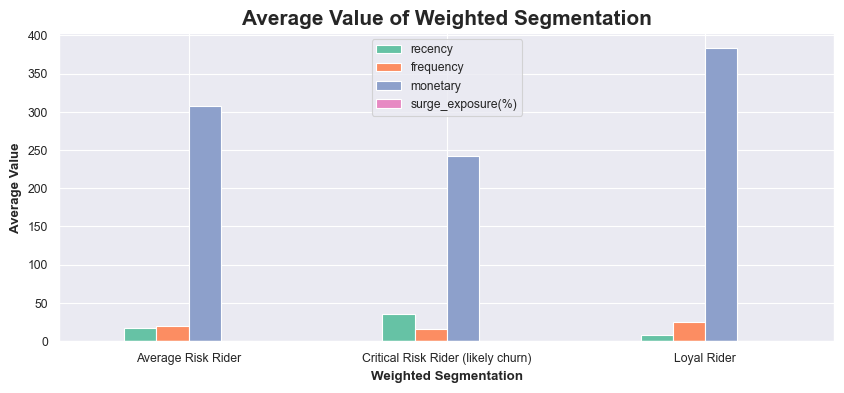

In [30]:
weighted_segmentation_col = ['recency', 'frequency', 'monetary','surge_exposure(%)']
avg_weighted_segmentation = rfm_table.groupby('weighted_segmentation')[weighted_segmentation_col].mean().reset_index()
avg_weighted_segmentation.plot(x='weighted_segmentation',kind='bar', figsize=(10,4))
plt.title('Average Value of Weighted Segmentation', fontsize=15, weight='bold')
plt.xticks(rotation=0)
plt.xlabel('Weighted Segmentation', weight='bold')
plt.ylabel('Average Value', weight='bold')
plt.show();

*Average Risk Rider*

- Shows values across all metrics, with monetary spending higher than recency, frequency, and surge exposure.

- Indicates balanced behaviour: neither highly loyal nor at immediate risk, but worth monitoring.

*Critical Risk Rider (likely churn)*

- Lower frequency and monetary values compared to other segments, signalling reduced engagement.

- Higher recency suggests long gaps since last activity, reinforcing churn risk.

*Loyal Rider*

- Highest monetary and frequency values, reflecting consistent and valuable usage.

- Lower recency indicates recent activity, confirming strong loyalty and ongoing engagement.

In [31]:
weighted_grp = rfm_table['weighted_segmentation'].value_counts().reset_index()
weighted_grp

,weighted_segmentation,count
0,Average Risk Rider,4548
1,Critical Risk Rider (likely churn),2920
2,Loyal Rider,2532


### Visualizing the distribution of Weighted Segments

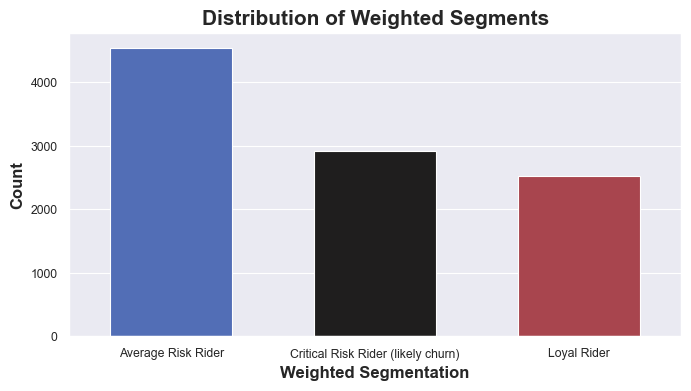

In [32]:
plt.figure(figsize=(7,4))
sns.barplot(x='weighted_segmentation', y='count', data=weighted_grp, palette='icefire', width=0.6)
plt.title('Distribution of Weighted Segments', fontsize=15, weight='bold')
plt.xlabel('Weighted Segmentation', fontsize=12, weight='bold')
plt.ylabel('Count', fontsize=12, weight='bold')
plt.tight_layout()
plt.show();

# 📊 Insights and Recommendations from Weighted Segment Distribution

## Overview
The bar chart titled *Distribution of Weighted Segments* shows how RideWise customers are distributed across three weighted categories: **Medium**, **Low**, and **High**. These weights likely reflect a composite score derived from Recency, Frequency, and Monetary (RFM) metrics, with Recency carrying the highest influence due to its predictive power for churn.

## Segment Breakdown

### 🟨 Average Risk Riders (Most Populated)
- **Observation**: This group has the highest count, exceeding 5,000 riders.
- **Interpretation**: These customers show moderate engagement — they ride fairly often, spend a reasonable amount, and haven't gone too long since their last ride.
- **Risk Level**: Medium churn risk. They are stable but not deeply loyal.
- **Recommendation**:
  - Introduce **commuter bundles** or **tiered loyalty perks** to nudge them toward higher engagement.
  - Use **personalized nudges** (e.g., “You’re close to unlocking a reward”) to increase frequency and spend.
  - Monitor recency trends — if their ride gaps widen, they may slip into the low segment.

### 🟥 Critical Risk Riders (Second Largest)
- **Observation**: Slightly above 2,500 riders.
- **Interpretation**: These users are infrequent, low spenders, or haven’t used the service recently.
- **Risk Level**: High churn risk.
- **Recommendation**:
  - Launch **reactivation campaigns** with time-limited discounts or referral bonuses.
  - Use **exit-intent surveys** to understand why usage dropped (price, competition, relevance).
  - Consider segmenting further into “Dormant” vs. “Explorers” — some may be new users who never converted.

### 🟩 Loyal Riders (Smallest Group)
- **Observation**: Just under 2,500 riders.
- **Interpretation**: These are your **most valuable customers** — frequent riders, high spenders, and recently active.
- **Risk Level**: Low churn risk, but high revenue impact if lost.
- **Recommendation**:
  - Offer **VIP loyalty programs** (priority support, exclusive offers).
  - Use **predictive churn flags** — even small drops in frequency or recency should trigger alerts.
  - Invite them to **beta-test new features** or provide feedback — this deepens emotional loyalty.

## Business Recommendations

- **Retention First**: Focus on Critical and Average Risk Riders with tailored incentives and reactivation flows.
- **Loyalty Deepening**: Protect and grow the Loyal Riders with exclusive benefits and early access programs.
- **Real-Time Monitoring**: Use weighted scores to trigger alerts when valuable users show signs of disengagement.
- **Marketing Optimization**: Allocate budget proportionally — more spend on Average/LoyalRiders retention, less on broad acquisition.

## Final Thought
This distribution confirms that RideWise has a strong mid-tier base but must act decisively to prevent churn and convert moderate users into loyalists. Weighted segmentation gives you the precision to do just that — aligning perfectly with your project goals of **churn prediction**, **real-time analytics**, and **optimized marketing**.


In [33]:
df['user_id'].nunique()

10000

In [34]:
rfm_table.head(3).reset_index()

,user_id,recency,frequency,monetary,surge_exposure(%),r,f,m,s,rfm_concat,rfm_score,riders_segmentation,weighted_score,weighted_segmentation
0,R00000,27,25,366.05,0.280000,2,4,4,2,244,12,Regular Commuters,3.0,Average Risk Rider
1,R00001,7,14,180.53,0.214286,4,1,1,1,411,7,Occasional Riders,2.2,Average Risk Rider
2,R00002,16,24,378.99,0.375000,2,4,4,3,244,13,Regular Commuters,3.1,Loyal Rider


In [35]:
rfm_table.to_csv('C:/Users/User/Desktop/ridewise/data/processed_data/rfms_table.csv')